## Question 1: Solving Stochastic Growth Model Numerically

### 1. Deriving the deterministic steady state analytically.

If productivity is non-random, we can drop the expectation operator:
$$\max_{\{c_t\}_{t=0}^\infty} \sum_{t=0}^{\infty} \beta^t \log(c_t).$$

Similarly, with $z_t = 0, \forall t$ we have the following simplified resource constraint:
$$c_t + k_{t+1} = k_t^\theta + (1-\delta)k_t \implies c_t = k_t^\theta + (1-\delta)k_t - k_{t+1}.$$

We can then write the Bellman equation where $k$ is the state variable. Substituting for $c$, we treat $k'$ as the choice variable and have:
$$V(k) = \max_{k'} \left\{ \log(k^\theta + (1-\delta)k - k') + \beta V(k') \right\}.$$

To find the steady state, we first derive the first-order condition.
$$\frac{\partial}{\partial k'}: \quad \beta V'(k') = \frac{1}{c}$$

Applying the envelope theorem to the state variable we obtain
$$V'(k) = \frac{1}{c} (\theta k^{\theta-1} + 1 - \delta).$$
By pushing the time one period forward, we can substitute and finally find the euler equation:
$$\frac{c'}{c} = \beta (1 - \delta + \theta (k')^{\theta-1}).$$

In the steady state, all variables are constant and thus also consumption growth is stable. By setting $c'/c = 1$, we then get:
$$1 = \beta (1 - \delta + \theta k^{\theta-1}).$$
Solving for $k$ we retrieve the steady state level of capital:
$$k^*_{ss} = \left[ \frac{\theta}{\frac{1}{\beta} - (1-\delta)} \right]^{\frac{1}{1-\theta}}.$$

If we impose the steady state to the (deterministic) resource constraint we know that $c^*_{ss} = (k^*_{ss})^\theta - \delta k^*_{ss}$, yielding

$$c^*_{ss} = \left[ \frac{\theta}{\frac{1}{\beta} - (1-\delta)} \right]^{\frac{\theta}{1-\theta}}-\delta \left[ \frac{\theta}{\frac{1}{\beta} - (1-\delta)} \right]^{\frac{1}{1-\theta}}$$
for the value of steady state consumption.

### 2. Numerically solving for the policy functions.

The following parameters are used:
- $\delta = 0.1$
- $\theta = 0.4$
- $\beta = 0.96$
- $q = 0.7$
- $\sigma = 0.1$

The transition matrix is thus

$$\begin{bmatrix} q & 1-q \\ 1-q & q \end{bmatrix} = \begin{bmatrix} P_{11} & P_{12} \\ P_{21} & P_{22} \end{bmatrix} = \begin{bmatrix} 0.7 & 0.3 \\ 0.3 & 0.7 \end{bmatrix}$$

and the (productivity) state space becomes $\{\sigma, -\sigma\} = \{0.1,-0.1\}.$ 

Given states $z_i, z_j \in \{0.1,-0.1\}$, this (symmetric) markov chain describes the conditional probability $P_{ij}$ of moving from the productivity state $z_i$ to the state $z_j$. The diagonal entries ($q$) correspond to the probability of staying on the same productivity level from one period to the other (i.e. $z_i = z_j$), while the off-diagonal entries ($1-q$) correspond to the probability of moving from $z_i$ to $z_j$ such that $z_i \neq z_j$ (i.e. leaving the previous state).

We can write the Bellman equation using conditional expectation:
$$V(k, z) = \max_{k'} \left\{ \log\left(e^{z} k^\theta + (1-\delta)k - k'\right) + \beta \mathbb{E} \left[V(k', z') \, \middle| \, z\right] \right\}.$$

Define $z_1 = 0.1$ and $z_2 = -0.1$. By knowing the current level of $k$ as well as today's productivity parameter $z_i$, we can expand the conditional expectation using the transition probabilities,
$$V(k, z_i) = \max_{k'} \left\{ \log\left(e^{z_i} k^\theta + (1-\delta)k - k'\right) + \beta \sum_{j=1}^2 P_{ij} V(k', z_j) \right\}$$
which gives us a system of (two) Bellman equations, one for each possible productivity state.

In fact, because of the symmetry we can also relate the two value functions and write
$$\begin{cases} 
V_L(k) = \max_{k'} \left\{ \log\left(e^{-0.1} k^\theta + (1-\delta)k - k'\right) + \beta \left[ q V_L(k') + (1-q) V_H(k') \right] \right\} \\
V_H(k) = \max_{k'} \left\{ \log\left(e^{0.1} k^\theta + (1-\delta)k - k'\right) + \beta \left[ (1-q) V_L(k') + q V_H(k') \right] \right\},
\end{cases}$$
where $V_L$ is the value function in the low state ($z=-0.1$) and $V_H$ in the high state ($z=0.1$).

In [1]:
using LinearAlgebra, Statistics, Interpolations, Optim, Plots

# Parameters
β = 0.96
δ = 0.10
θ = 0.4
σ = 0.1
q = 0.7

# Transition Matrix P
P = [q     1-q; 
     1-q   q]

z_vals = [σ, -σ] # High state, Low state

2-element Vector{Float64}:
  0.1
 -0.1

To initialise the grid for capital we use the deterministic steady state derived in the previous question implied by the given parameters as a reference level.

In [23]:
k_ss_deterministic = (( θ / ((1/β) - (1-δ)) )^(1/θ))

k_min = 0.1 * k_ss_deterministic
k_max = 2 * k_ss_deterministic
nk = 100
k_grid = range(k_min, k_max, length=nk)

1.3396174312528164:0.25709829488690417:26.792348625056327

In [25]:
# Initialise value and policy functions
# V is a nk by 2 matrix because we have 2 different possible z states

V_guess_grid = zeros(nk, 2)
V_new_grid = zeros(nk, 2)
policy_k_grid = zeros(nk, 2)

100×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 ⋮    
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0
 0.0  0.0

Starting VFI...
Converged in 1 iterations.
Steady State High z: 7.252877593872588
Steady State Low z: 4.424796291844783


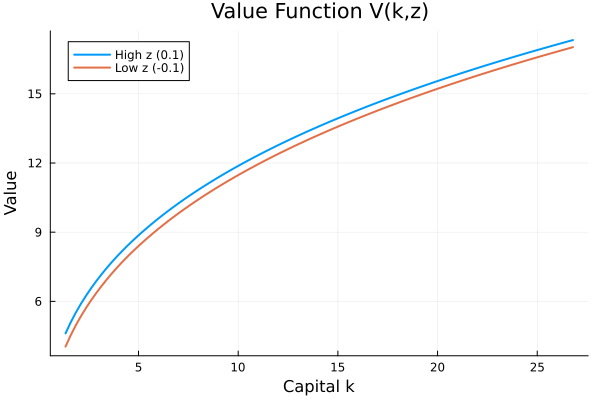

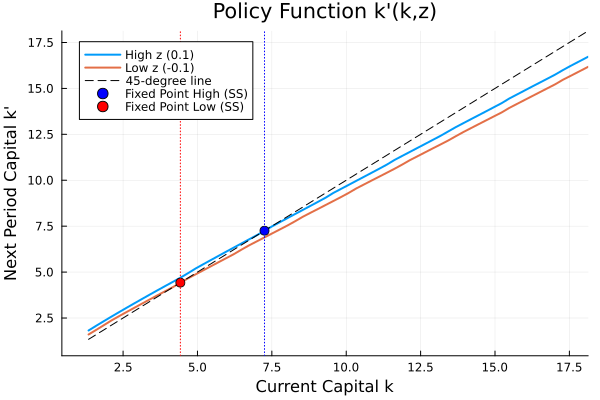

In [ ]:
# Bellman Operator
# We define a function that takes the current interpolated value function and solves the max problem for a specific k and z
function solve_bellman_at_point(V_interp_high, V_interp_low, k_val, z_idx)

    z = z_vals[z_idx]
    
    # Define the objective function to maximise: u(c) + β * E[V(k')]
    function objective(k_prime)
        # Resource constraint: c = y + (1-δ)k - k'
        c = exp(z)*k_val^θ + (1-δ)*k_val - k_prime
        
        if c <= 0
            return -1e10 # Penalty for negative consumption
        end
        
        # Expected continuation value
        # P[z_idx, 1] is prob of going to High state (index 1)
        # P[z_idx, 2] is prob of going to Low state (index 2)
        expected_value = P[z_idx, 1] * V_interp_high(k_prime) + P[z_idx, 2] * V_interp_low(k_prime)
        
        return log(c) + β * expected_value
    end

    # Search for the optimal k' between a small number and total available resources
    max_resources = exp(z)*k_val^θ + (1-δ)*k_val
    res = maximize(objective, k_grid[1], max_resources)
    
    return Optim.maximum(res), Optim.maximizer(res)
end

# VFI Loop

max_iter = 1000
tol = 1e-5
dist = 1.0
iter = 0

println("Starting VFI...")

while dist > tol && iter < max_iter
    global V_guess_grid, policy_k_grid, dist, iter # Access global variables
    
    # 1. Interpolate the current guess (V_guess_grid)
    # We create two interpolation functions: one for High state, one for Low state
    V_interp_high = LinearInterpolation(k_grid, V_guess_grid[:, 1], extrapolation_bc=Line())
    V_interp_low  = LinearInterpolation(k_grid, V_guess_grid[:, 2], extrapolation_bc=Line())
    
    # 2. Update V_new_grid by solving the Bellman equation at each grid point
    for i in 1:nk # Loop over capital grid
        k_val = k_grid[i]
        
        # High state (z index 1)
        val_h, pol_h = solve_bellman_at_point(V_interp_high, V_interp_low, k_val, 1)
        V_new_grid[i, 1] = val_h
        policy_k_grid[i, 1] = pol_h
        
        # Low state (z index 2)
        val_l, pol_l = solve_bellman_at_point(V_interp_high, V_interp_low, k_val, 2)
        V_new_grid[i, 2] = val_l
        policy_k_grid[i, 2] = pol_l
    end
    
    # 3. Calculate distance and update
    dist = maximum(abs.(V_new_grid - V_guess_grid))
    V_guess_grid = copy(V_new_grid) # Update the guess for next iteration
    
    iter += 1
    if iter % 10 == 0
        println("Iteration: $iter, Distance: $dist")
    end
end

println("Converged in $iter iterations.")

# Find "stochastic steady states" (fixed points of policy functions where k' = k)
# use interpolation to find the exact crossing point
interp_pol_high = LinearInterpolation(k_grid, policy_k_grid[:, 1] .- k_grid, extrapolation_bc=Line())
interp_pol_low  = LinearInterpolation(k_grid, policy_k_grid[:, 2] .- k_grid, extrapolation_bc=Line())

# Find roots using Optim or just finding zero crossing
using Roots
k_ss_high = find_zero(k -> interp_pol_high(k), (k_min, k_max))
k_ss_low  = find_zero(k -> interp_pol_low(k), (k_min, k_max))

println("Steady State High z: $k_ss_high")
println("Steady State Low z: $k_ss_low")

# Plot

# Value Function V(k, z)
p1 = plot(k_grid, V_guess_grid[:, 1], label="High z (0.1)", title="Value Function V(k,z)", lw=2)
plot!(p1, k_grid, V_guess_grid[:, 2], label="Low z (-0.1)", lw=2)
xlabel!(p1, "Capital k")
ylabel!(p1, "Value")

# Policy Function g(k, z) = k'
# Zoom in around the steady states
zoom_min = min(k_ss_low, k_ss_high) * 0.1
zoom_max = max(k_ss_low, k_ss_high) * 2.5

p2 = plot(k_grid, policy_k_grid[:, 1], label="High z (0.1)", title="Policy Function k'(k,z)", legend=:topleft, lw=2)
plot!(p2, k_grid, policy_k_grid[:, 2], label="Low z (-0.1)", lw=2)
plot!(p2, k_grid, k_grid, linestyle=:dash, color=:black, label="45-degree line")

# Add markers for steady states
scatter!(p2, [k_ss_high], [k_ss_high], color=:blue, label="Fixed Point High (SS)", markersize=5)
scatter!(p2, [k_ss_low], [k_ss_low], color=:red, label="Fixed Point Low (SS)", markersize=5)

# Add vertical lines for steady states
vline!(p2, [k_ss_high], linestyle=:dot, color=:blue, label="")
vline!(p2, [k_ss_low], linestyle=:dot, color=:red, label="")

# Set limits to zoom in
xlims!(p2, zoom_min, zoom_max)
ylims!(p2, zoom_min, zoom_max)

xlabel!(p2, "Current Capital k")
ylabel!(p2, "Next Period Capital k'")

display(p1)
display(p2)